In [ ]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""


This code example demonstrates how to use a pre-trained residual network to solve an image classification problem, using a picture of a dog. More context for this code example can be found in the section "Programming Example: Use a Pretrained ResNet Implementation" in Chapter 8 in the book Learning Deep Learning by Magnus Ekman (ISBN: 9780137470358).

We start with a number of import statements.

In [3]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In the next code snippet we load the image and transform it to be suitable to feed into the pretrained network. The transformation involves normalizing, converting to tensor, and resizing. The parameters used in the normalization steps are the mean and standard deviation for each color channel from the training dataset that was used to train the pretrained model. These values are documented on pytorch.org.

Finally, since the network expects an array of multiple images, so we add a fourth dimension using the unsqueeze() method.


In [15]:
# Load and preprocess image.
image = Image.open('../data/dog.jpg')
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) # Parameters are documented at pytorch.org.
input_tensor = preprocess(image)

# Convert to 4-dimensional tensor.
inputs = input_tensor.unsqueeze(0)

The final code snippet starts with loading the pretrained ResNet-50 model. We put the model in evaluation mode since we will use it for inference and not training. We then move the model and the input image to the GPU (if present).

We then do a prediction by calling the model with the image as input. By doing the call to a model inside the scope of a torch.no_grad() statement, PyTorch is told that it does not need to track information needed to automatically be able to calculate gradients for the model during this call. This reduces the amount of computation needed and makes the code snippet run faster. In this case when we only do a single call to the model it is not that important, but it can make a difference when doing inference for a large number of images.

As we have previously seen, when implementing a model in PyTorch, the activation function for the final SoftMax layer is omitted since it is included in the PyTorch implementation of the cross-entropy loss function. However, that is only the case when using a model for training. When using a model for inference, we therefore need to run the outputs through a softmax function to convert the logits (weighted sums) to probabilities. This is done with a call to torch.nn.functiona.softmax().

We sort the resulting probabilities with a call to torch.sort() which returns both the sorted values and the indices of their locations in the vector. We are interested in the indices (each index corresponds to an image category). We then print out the indices of the top five image categories, as well as their corresponding probabilities. The calls to item() converts the values from the PyTorch tensor datatype to a standard Python datatype.

This program prints out only the class ID, and not the class names. To also print the class name you would need to add code to convert from class ID to class name using a look-up table. The mapping between class ID and class name is available for download in various formats from various sources. One good format is found here:
https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a


ImageNet class: 248 , probability = 0.167
ImageNet class: 250 , probability = 0.149
ImageNet class: 797 , probability = 0.112
ImageNet class: 151 , probability = 0.111
ImageNet class: 172 , probability = 0.080


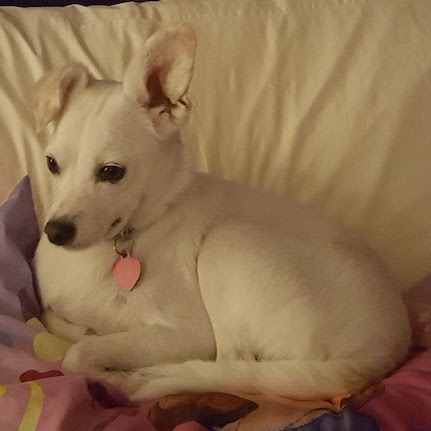

In [18]:
# Load the pre-trained model.
model = torchvision.models.resnet50(pretrained=True)
model.eval()

# Transfer model to GPU.
model.to(device)

# Do prediction.
inputs = inputs.to(device)
with torch.no_grad():
    outputs = model(inputs)

# Convert to probabilities, since final SoftMax activation is not in pretrained model.
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

# Print class ID for top 5 predictions.
_, indices = torch.sort(probabilities, descending=True)
for i in range(0, 5):
    print('ImageNet class:', indices[i].item(), ', probability = %4.3f' % probabilities[indices[i]].item())

# Show image.
image.show()
